## Applying the bias scan tool on a BERT disinformation classifier
In this notebook, the bias scan tool is applied on a BERT-based disinformation classifier. The bias scan tool is based on an implementation of the k-means Hierarchical Bias Aware Clustering (HBAC) method\*. The python script `./helper_functions.py` contains functions that execute the bias scan. A conceptual description how the bias scan works, including the rationale why k-means is chosen as a clustering algorithm and paramater choices, can be found in the [bias scan tool report](https://github.com/NGO-Algorithm-Audit/AI_Audit_Challenge/blob/master/Bias_scan_tool_report.docx).

The classifier is used to make predictions on the Twitter15\*\* data set. Details on pre-processing steps performed on this dataset are provided in the `../data/Twitter_dataset/Twitter_preprocessing.ipynb` notebook. Details on training the BERT disinformation classifier is provided in the `../classification_models/BERT_disinformation_classifier/BERT_Twitter_classifier.ipynb` notebook.

This notebook is structured as follows:
1. Load data and pre-processing
2. Bias scan using k-means clustering
3. Clustering results
4. Statistical testing of inter-cluster difference 

\* Misztal-Radecka, Indurkya, *Information Processing and Management*. Bias-Aware Hierarchical Clustering for detecting the discriminated groups of users in recommendation systems (2021).

\*\* Liu, Xiaomo and Nourbakhsh, Armineh and Li, Quanzhi and Fang, Rui and Shah, Sameena, *Proceedings of the 24th ACM International on Conference on Information and Knowledge Management* (2015) [[link to dataset]](https://www.dropbox.com/s/7ewzdrbelpmrnxu/rumdetect2017.zip?dl=0&file_subpath=%2Frumor_detection_acl2017)

### Load libraries

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

# IPython
from IPython.display import Markdown, display

# matplotlib
import matplotlib.pyplot as plt

# helper functions
from helper_functions import *

# welch's t-test
import scipy.stats as stats

warnings.filterwarnings('ignore')

### 1. Load data and pre-processing

In [2]:
# read data
path = '../classification_models/BERT_disinformation_classifier/pred_BERT.csv'
df_pred = pd.read_csv(path)

# change column names
df_pred.columns = ['text','predicted_class','true_class']

# Calculating absolute errors
df_pred['errors'] = abs(df_pred['predicted_class'] - df_pred['true_class'])
df_pred.head()

,text,predicted_class,true_class,errors
0,marlboro man dies of smoking-related disease U...,0,1,1
1,#oklahoma prosecutor files formal notification...,0,0,0
2,#mexico: doubts grow over the fate of 43 missi...,0,0,0
3,who killed deandre joshua - and why? still mor...,1,0,1
4,i feel some type of way. URL,1,1,0


#### Add features to data

In [3]:
path_feat = '../data/Twitter_dataset/twitter_full.csv'
df_feat = pd.read_csv(path_feat)
df_feat.head(2)

,#followers,user_engagement,verified,depth,user_id1,tweet_id1,user_id2,length,#hashs,#mentions,#URLs,sentiment_score,text,label
0,15375121,72.567469,1,0.0,ROOT,489800427152879616,2467791,95,0,0,2,-0.3182,malaysia airlines says it lost contact with pl...,1
1,3673898,55.294333,1,0.0,ROOT,560474897013415936,59553554,118,0,1,1,0.8398,for just $1 you can get a free jr. frosty with...,1


#### Data cleaning

In [4]:
df_full = pd.merge(df_pred, df_feat, on=['text'])

# remove certain columns
df_full = df_full.drop(columns=['depth', 'user_id1', 'user_id2','label'])

# features
features = df_full.drop(['text','predicted_class', 'true_class', 'errors'], axis=1)
features.head()

df_full.head()

,text,predicted_class,true_class,errors,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score
0,marlboro man dies of smoking-related disease U...,0,1,1,2881966,48.857582,1,427846006600777729,52,0,0,2,0.0000
1,#oklahoma prosecutor files formal notification...,0,0,0,2432446,4.103050,1,517850508380618752,124,3,0,0,-0.8442
2,#mexico: doubts grow over the fate of 43 missi...,0,0,0,4144151,9.042582,1,520630231531802624,102,1,0,2,-0.7184
3,who killed deandre joshua - and why? still mor...,1,0,1,606870,6.919301,1,539833716852273152,117,0,0,1,-0.8720
4,i feel some type of way. URL,1,1,0,2528852,11.271492,1,524320261667950592,28,0,0,1,0.0000


#### Data initialization

In [5]:
full_data = initialize_dataset(df_full,features)
full_data.head()

,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
0,-0.249684,-0.063442,0.498224,-1.230690,-1.607344,-0.513855,-0.325831,0.921514,0.423952,0.8,0,1,1,0,-1
1,-0.299704,-0.901957,0.498224,0.305262,1.519500,4.912457,-0.325831,-2.054385,-1.463204,0.0,0,0,0,0,-1
2,-0.109236,-0.809411,0.498224,0.352699,0.564075,1.294915,-0.325831,0.921514,-1.181986,0.0,0,0,0,0,-1
3,-0.502843,-0.849192,0.498224,0.680412,1.215501,-0.513855,-0.325831,-0.566435,-1.525350,0.8,1,0,1,0,-1
4,-0.288977,-0.767650,0.498224,0.415671,-2.649625,-0.513855,-0.325831,-0.566435,0.423952,0.0,1,1,0,0,-1


### 2. Bias scan using k-means clustering

Clustering algorithms parameters:

In [6]:
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 300,
    "random_state": 10,
}

Specify:
- Minimal splittable cluster size
- Minimal acceptable cluster size

In [7]:
# minimal splittable cluster size
split_cluster_size = round(0.05 * len(full_data))
print("minimal splittable cluster size: ", split_cluster_size)

# minimal acceptable cluster size
acc_cluster_size = round(0.03 * len(full_data))
print("minimal splitacceptabletable cluster size: ", acc_cluster_size)

minimal splittable cluster size:  9
minimal splitacceptabletable cluster size:  5


Performing bias scan using helper functions.

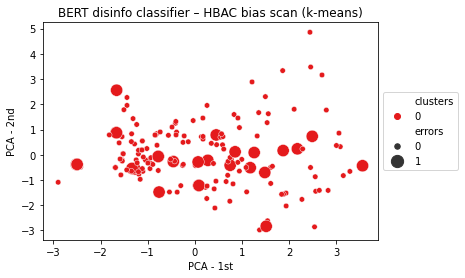

average_accuracy is:  0.8352272727272727


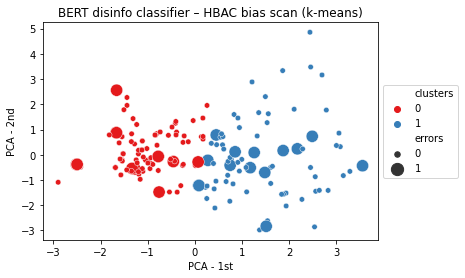

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1


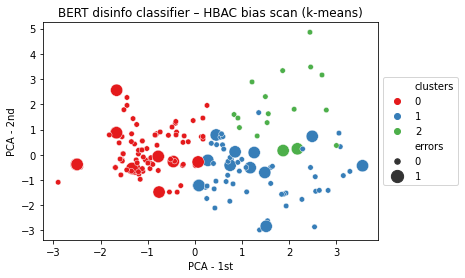

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1


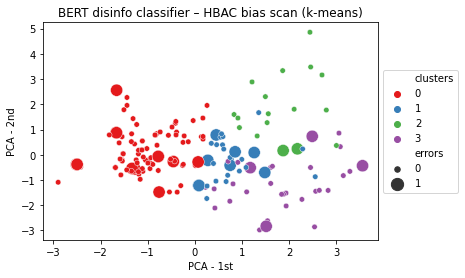

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1


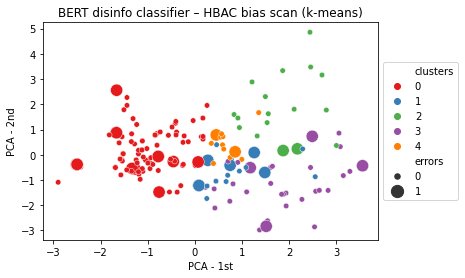

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 1


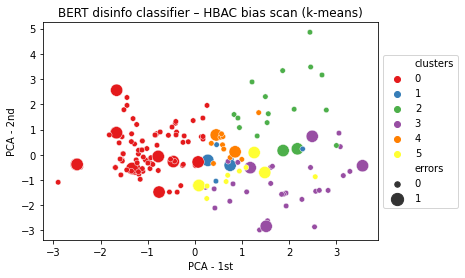

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 5


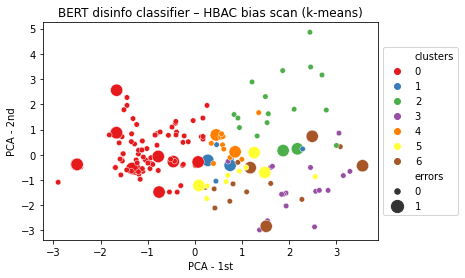

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 6
--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 5


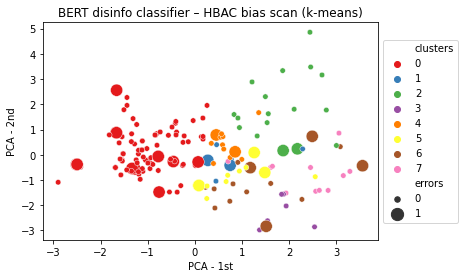

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 6
--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 5
MAX_ITER
[0.0009182736455463712, 0.0020718003190880155, 0.005799712345541313, 0.009496384241532839, 0.011577104055554661, 0.011577104055554661, 0.017188435596335577, 0.017188435596335577, 0.017188435596335577, 0.017188435596335577, 0.017188435596335577, 0.017188435596335577, 0.017188435596335577, 0.017188435596335577, 0.019413398528335846, 0.019413398528335846, 0.019413398528335846, 0.019413398528335846]


In [8]:
MAX_ITER = 20
x = 0 # initial cluster number
initial_bias = 0
pca_plot(full_data)
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = 9
minimal_acceptable_cluster_size = 5
# minimal_splittable_cluster_size = round(0.05 * len(full_data))
# minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        
        # calculate variance for cluster
        variance_list.append(calculate_variance(full_data)) 
        
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # k-means clustering 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    # with get_max_abs_bias, but now it only finds the discriminated clusters
    max_abs_bias = get_max_negative_bias(full_data) 
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size):
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        pca_plot(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(variance_list)

### 3. Analysing clustering results

Identifying highest biased cluster

In [16]:
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
print(f"cluster {c} has the highest discrimination bias")
print("#elements in highest biased cluster:", len(highest_biased_cluster))

0 has bias 0.030303030303030276
2 has bias 0.052164261931187506
4 has bias -0.00203252032520318
6 has bias -0.1313932980599647
1 has bias -0.17450980392156867
5 has bias -0.21212121212121215
3 has bias 0.1823899371069182
cluster 5 has the highest discrimination bias
#elements in highest biased cluster: 11


Accuracy of classifier on full dataset and on cluster with highest discrimination bias.

In [19]:
accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)

General accuracy of classifier on this dataset: 0.8352272727272727


Select and print discriminated cluser.

In [20]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

Number of instances in discriminated cluster: 11
Number of errors in discriminated clusters:  4


,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
20,0.818782,-0.504531,0.498224,-3.993434,1.693213,-0.513855,-0.325831,-2.054385,0.423952,0.0,0,0,0,5,-1.0
53,-0.328480,-0.097789,0.498224,-1.581861,0.433790,-0.513855,-0.325831,-0.566435,0.423952,0.0,1,1,0,5,-1.0
80,-0.526359,-0.033811,0.498224,-1.583059,0.216648,-0.513855,-0.325831,-0.566435,0.821636,0.0,0,0,0,5,-1.0
82,-0.228727,0.585315,0.498224,-2.294693,-0.955918,-0.513855,-0.325831,-0.566435,0.423952,0.0,0,0,0,5,-1.0
89,-0.479167,-0.038694,0.498224,-1.581945,1.302358,-0.513855,-0.325831,-0.566435,1.277442,0.0,1,1,0,5,-1.0
125,-0.568767,-0.936721,0.498224,-1.927772,1.258930,-0.513855,-0.325831,-0.566435,1.110455,0.8,0,1,1,5,-1.0
139,0.254462,0.052834,0.498224,-1.229347,-0.651919,-0.513855,-0.325831,-0.566435,1.184001,0.8,0,1,1,5,-1.0
140,0.247318,0.046874,0.498224,-1.232112,-0.651919,-0.513855,-0.325831,-0.566435,1.184001,0.8,0,1,1,5,-1.0
153,0.739568,0.084540,0.498224,-2.044804,-0.565063,-0.513855,-0.325831,-0.566435,0.761727,0.0,0,0,0,5,-1.0
160,-0.228259,0.587521,0.498224,-2.302204,1.215501,1.294915,-0.325831,-0.566435,0.423952,0.8,0,1,1,5,-1.0


### 4. Statistical testing of inter-cluster difference 

Compute difference between cluster with highest discrimination bias and rest of dataset.

In [40]:
not_discriminated = full_data[full_data['clusters']!=c]
difference = (discriminated_cluster.mean()) - (not_discriminated.mean()) 
diff_dict = difference.to_dict()
difference

#followers        -0.028935
user_engagement   -0.064900
verified           0.531439
tweet_id1         -2.070784
length             0.315316
#hashs            -0.197320
#mentions         -0.347554
#URLs             -0.748484
sentiment_score    0.996416
scaled_errors      0.169697
predicted_class   -0.200000
true_class         0.145455
errors             0.212121
clusters           3.648485
new_clusters      -0.096970
dtype: float64

Unscaling the data. Print summary of cluster with highest discrimination bias and the rest of data.

In [41]:
# unscaling the discriminated cluster
unscaled_discriminated = full_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = full_data.drop(discriminated_cluster.index)

display(unscaled_remaining.describe())
display(unscaled_discriminated.describe())

print(discriminated_cluster.index)

,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,0.001808,0.004056,-0.033215,0.129424,-0.019707,0.012333,0.021722,0.046780,-0.062276,0.121212,0.472727,0.490909,0.151515,1.351515,-0.903030
std,1.028893,1.029981,1.027332,0.875747,1.006050,1.018861,1.032267,1.012754,0.996021,0.287713,0.500775,0.501439,0.359642,1.946874,0.369974
min,-0.570363,-0.978823,-2.007130,-2.589796,-2.779910,-0.513855,-0.325831,-2.054385,-1.652099,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,-0.559650,-0.820911,0.498224,0.080027,-0.478206,-0.513855,-0.325831,-0.566435,-0.915969,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,-0.385781,-0.131471,0.498224,0.426134,0.129792,-0.513855,-0.325831,0.921514,0.423952,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
75%,0.030059,0.333825,0.498224,0.607816,0.520647,-0.513855,-0.325831,0.921514,0.423952,0.000000,1.000000,1.000000,0.000000,3.000000,-1.000000
max,5.772971,3.181331,0.498224,1.264540,2.214354,4.912457,6.555729,0.921514,2.426233,0.800000,1.000000,1.000000,1.000000,6.000000,1.000000


,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
count,11.000000,11.000000,1.100000e+01,11.000000,11.000000,11.000000,1.100000e+01,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.0
mean,-0.027126,-0.060843,4.982238e-01,-1.941360,0.295609,-0.184988,-3.258314e-01,-0.701704,0.934140,0.290909,0.272727,0.636364,0.363636,5.0,-1.0
std,0.487612,0.444462,1.164412e-16,0.774703,0.947857,0.731684,5.822059e-17,0.448634,0.553520,0.403620,0.467099,0.504525,0.504525,0.0,0.0
min,-0.568767,-0.936721,4.982238e-01,-3.993434,-0.955918,-0.513855,-3.258314e-01,-2.054385,0.423952,0.000000,0.000000,0.000000,0.000000,5.0,-1.0
25%,-0.403823,-0.256302,4.982238e-01,-2.169748,-0.608491,-0.513855,-3.258314e-01,-0.566435,0.423952,0.000000,0.000000,0.000000,0.000000,5.0,-1.0
50%,-0.228259,-0.033811,4.982238e-01,-1.583727,0.216648,-0.513855,-3.258314e-01,-0.566435,0.821636,0.000000,0.000000,1.000000,0.000000,5.0,-1.0
75%,0.250890,0.068687,4.982238e-01,-1.581903,1.237215,-0.513855,-3.258314e-01,-0.566435,1.184001,0.800000,0.500000,1.000000,1.000000,5.0,-1.0
max,0.818782,0.587521,4.982238e-01,-1.229347,1.693213,1.294915,-3.258314e-01,-0.566435,2.240469,0.800000,1.000000,1.000000,1.000000,5.0,-1.0


Int64Index([20, 53, 80, 82, 89, 125, 139, 140, 153, 160, 161], dtype='int64')


In [42]:
unscaled_discriminated

,#followers,user_engagement,verified,tweet_id1,length,#hashs,#mentions,#URLs,sentiment_score,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
20,0.818782,-0.504531,0.498224,-3.993434,1.693213,-0.513855,-0.325831,-2.054385,0.423952,0.0,0,0,0,5,-1.0
53,-0.328480,-0.097789,0.498224,-1.581861,0.433790,-0.513855,-0.325831,-0.566435,0.423952,0.0,1,1,0,5,-1.0
80,-0.526359,-0.033811,0.498224,-1.583059,0.216648,-0.513855,-0.325831,-0.566435,0.821636,0.0,0,0,0,5,-1.0
82,-0.228727,0.585315,0.498224,-2.294693,-0.955918,-0.513855,-0.325831,-0.566435,0.423952,0.0,0,0,0,5,-1.0
89,-0.479167,-0.038694,0.498224,-1.581945,1.302358,-0.513855,-0.325831,-0.566435,1.277442,0.0,1,1,0,5,-1.0
125,-0.568767,-0.936721,0.498224,-1.927772,1.258930,-0.513855,-0.325831,-0.566435,1.110455,0.8,0,1,1,5,-1.0
139,0.254462,0.052834,0.498224,-1.229347,-0.651919,-0.513855,-0.325831,-0.566435,1.184001,0.8,0,1,1,5,-1.0
140,0.247318,0.046874,0.498224,-1.232112,-0.651919,-0.513855,-0.325831,-0.566435,1.184001,0.8,0,1,1,5,-1.0
153,0.739568,0.084540,0.498224,-2.044804,-0.565063,-0.513855,-0.325831,-0.566435,0.761727,0.0,0,0,0,5,-1.0
160,-0.228259,0.587521,0.498224,-2.302204,1.215501,1.294915,-0.325831,-0.566435,0.423952,0.8,0,1,1,5,-1.0


####  Test to check statistical significance of inter-cluster difference (per feature)
Applying a Welch’s two-samples t-test for unequal variances to examine whether the differences in means for each feature are statistically significant and store results in a dictionary.

In [43]:
welch_dict = {}

features = ['#followers', 'user_engagement', 'verified', 'length', '#hashs', '#mentions', '#URLs', 'sentiment_score']
    
for i in features:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    
    # attach to dictionary
    welch_dict[i] = welch_i.pvalue
    
welch_dict

{'#followers': 0.8648651055361747,
 'user_engagement': 0.6825517375072445,
 'verified': 4.2756657613307334e-10,
 'length': 0.3090243880055268,
 '#hashs': 0.4154884608010311,
 '#mentions': 2.642534966488398e-05,
 '#URLs': 0.0001535252370177082,
 'sentiment_score': 7.617084068380749e-05}

p-values: A small p-value (p < 0.05) indicates that it is unlikely to observe inter-cluster difference due to chance.

In [44]:
dict(sorted(welch_dict.items(), key=lambda item: item[1]))

{'verified': 4.2756657613307334e-10,
 '#mentions': 2.642534966488398e-05,
 'sentiment_score': 7.617084068380749e-05,
 '#URLs': 0.0001535252370177082,
 'length': 0.3090243880055268,
 '#hashs': 0.4154884608010311,
 'user_engagement': 0.6825517375072445,
 '#followers': 0.8648651055361747}

In [47]:
cluster_analysis_df = pd.DataFrame([diff_dict, welch_dict]).T
cluster_analysis_df.columns = ['difference','p-value']
cluster_analysis_df.sort_values('p-value')

,difference,p-value
verified,0.531439,4.275666e-10
#mentions,-0.347554,2.642535e-05
sentiment_score,0.996416,7.617084e-05
#URLs,-0.748484,1.535252e-04
length,0.315316,3.090244e-01
#hashs,-0.197320,4.154885e-01
user_engagement,-0.064900,6.825517e-01
#followers,-0.028935,8.648651e-01
tweet_id1,-2.070784,NaN
scaled_errors,0.169697,NaN


#### Conclusion
Discriminatory bias by the classifier on the basis of:
- verified profile
- #mentions
- sentiment score **[include or exclude sentiment score?]**
- #URLs